# To predict the pitch types a batter may receive, follow these steps:

1. **Model Creation**: Build a model to predict the pitch type a batter is likely to receive based on selected features (e.g., pitcher, batter characteristics, etc.).
   
2. **Training**: Train the model using historical data with the relevant features identified.

3. **Simulation for Predictions**: After training, apply the model to each data point in the dataset, using the same identified features. This simulates the possible pitch types the batter may face under similar conditions (e.g., same pitchers, situations, etc.).

4. **Calculate Probabilities**: Count the model’s predictions for each pitch type to determine the probability distribution of the different pitches the batter may encounter.

5. **2024 Simulation**: Set the `GAME_YEAR` input to 2024 in the dataset to simulate predictions for the upcoming season, assuming all other feature values remain the same in 2024.



## Use selected features:
 'PITCHER_ID',
 
 'GAME_YEAR',
 
 'PITCH_NUMBER',
 
 'OUTS_WHEN_UP',
 
 'STRIKES',
 
 'ON_2B',
 
 'IF_FIELDING_ALIGNMENT_enc',
 
 'BALLS',
 
 'FLD_SCORE'

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import shap
import pandas as pd
import numpy as np
shap.initjs()

In [2]:
df = pd.read_csv('data.csv')

In [4]:
df.head()
print(df.shape)
df['PITCH_TYPE'].isna().sum()

(1286181, 56)


493

In [5]:
df = df.dropna(subset=['PITCH_TYPE'])
df.shape

(1285688, 56)

In [6]:
columns_to_drop = [
    'PLAYER_NAME', 'PITCH_NAME', 'GAME_PK', 'EVENTS', 'DESCRIPTION', 'TYPE', 
    'ZONE', 'PLATE_X', 'PLATE_Z', 'SZ_TOP', 'SZ_BOT',
    'BB_TYPE', 'HIT_LOCATION', 'HC_X', 'HC_Y', 'HIT_DISTANCE_SC', 
    'LAUNCH_SPEED', 'LAUNCH_ANGLE', 'ESTIMATED_BA_USING_SPEEDANGLE', 
    'ESTIMATED_WOBA_USING_SPEEDANGLE', 'WOBA_VALUE', 'WOBA_DENOM', 
    'BABIP_VALUE', 'ISO_VALUE', 'LAUNCH_SPEED_ANGLE', 'POST_AWAY_SCORE', 
    'POST_HOME_SCORE', 'POST_BAT_SCORE', 'POST_FLD_SCORE', 'DELTA_HOME_WIN_EXP', 
    'DELTA_RUN_EXP', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM'
]

# Drop the columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned['PITCH_TYPE'].unique()
df_cleaned.shape

(1285688, 22)

In [7]:
# Define the pitch type mapping
pitch_mapping = {
    # Fastball types
    'FA': 'FB', 'FF': 'FB', 'FC': 'FB', 'SI': 'FB', 'PO': 'FB',
    
    # Offspeed pitches
    'CH': 'OS', 'FO': 'OS', 'FS': 'OS', 'KN': 'OS', 'EP': 'OS',
    
    # Breaking ball pitches
    'CU': 'BB', 'CS': 'BB', 'KC': 'BB', 'SL': 'BB', 
    'ST': 'BB', 'SV': 'BB', 'SC': 'BB'
}

# Assuming df['PITCH_CODE'] is the column containing pitch codes
df_cleaned['PITCH_TYPE'] = df_cleaned['PITCH_TYPE'].map(pitch_mapping)

# Display the resulting DataFrame (optional)
df_cleaned.head()


,PITCH_TYPE,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_YEAR,INNING,INNING_TOPBOT,AT_BAT_NUMBER,PITCH_NUMBER,...,STRIKES,ON_1B,ON_2B,ON_3B,IF_FIELDING_ALIGNMENT,OF_FIELDING_ALIGNMENT,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE
0,FB,605141,608566,R,R,2021,1,Top,1,1,...,0,NaN,NaN,NaN,Standard,Standard,0,0,0,0
1,FB,605141,608566,R,R,2021,1,Top,1,2,...,0,NaN,NaN,NaN,Standard,Standard,0,0,0,0
2,FB,605141,608566,R,R,2021,1,Top,1,3,...,1,NaN,NaN,NaN,Strategic,Standard,0,0,0,0
3,FB,605141,608566,R,R,2021,1,Top,1,4,...,1,NaN,NaN,NaN,Strategic,Standard,0,0,0,0
4,FB,605141,608566,R,R,2021,1,Top,1,5,...,1,NaN,NaN,NaN,Standard,Standard,0,0,0,0


In [8]:
input_features = ['PITCHER_ID',
 'GAME_YEAR',
 'PITCH_NUMBER',
 'OUTS_WHEN_UP',
 'STRIKES',
 'ON_2B',
 'BAT_SIDE',
 'IF_FIELDING_ALIGNMENT',
 'BALLS',
 'FLD_SCORE']

df_fea = df_cleaned[input_features+['PITCH_TYPE', 'BATTER_ID']]

### Handle missing data & convert categorical into integer

In [9]:
df_fea[['ON_2B']] = df_fea[['ON_2B']].applymap(lambda x: 0 if pd.isna(x) else 1)
df_fea = df_fea.fillna({'IF_FIELDING_ALIGNMENT': 'Standard'})

/var/folders/1s/2gfv98317bnc5_7xb_2604sc0000gp/T/ipykernel_46172/2346060101.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fea[['ON_2B']] = df_fea[['ON_2B']].applymap(lambda x: 0 if pd.isna(x) else 1)
/var/folders/1s/2gfv98317bnc5_7xb_2604sc0000gp/T/ipykernel_46172/2346060101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fea[['ON_2B']] = df_fea[['ON_2B']].applymap(lambda x: 0 if pd.isna(x) else 1)


In [10]:
df_fea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285688 entries, 0 to 1286180
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   PITCHER_ID             1285688 non-null  int64 
 1   GAME_YEAR              1285688 non-null  int64 
 2   PITCH_NUMBER           1285688 non-null  int64 
 3   OUTS_WHEN_UP           1285688 non-null  int64 
 4   STRIKES                1285688 non-null  int64 
 5   ON_2B                  1285688 non-null  int64 
 6   BAT_SIDE               1285688 non-null  object
 7   IF_FIELDING_ALIGNMENT  1285688 non-null  object
 8   BALLS                  1285688 non-null  int64 
 9   FLD_SCORE              1285688 non-null  int64 
 10  PITCH_TYPE             1285688 non-null  object
 11  BATTER_ID              1285688 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 127.5+ MB


In [11]:
# Extract only the object-type columns
object_columns = df_fea.select_dtypes(include='object')

col_list = list(object_columns.columns)

for c in col_list:
    df_fea[c+'_enc'] = pd.factorize(df_fea[c])[0]

df_fea=df_fea.drop(columns=col_list)
df_fea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285688 entries, 0 to 1286180
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype
---  ------                     --------------    -----
 0   PITCHER_ID                 1285688 non-null  int64
 1   GAME_YEAR                  1285688 non-null  int64
 2   PITCH_NUMBER               1285688 non-null  int64
 3   OUTS_WHEN_UP               1285688 non-null  int64
 4   STRIKES                    1285688 non-null  int64
 5   ON_2B                      1285688 non-null  int64
 6   BALLS                      1285688 non-null  int64
 7   FLD_SCORE                  1285688 non-null  int64
 8   BATTER_ID                  1285688 non-null  int64
 9   BAT_SIDE_enc               1285688 non-null  int64
 10  IF_FIELDING_ALIGNMENT_enc  1285688 non-null  int64
 11  PITCH_TYPE_enc             1285688 non-null  int64
dtypes: int64(12)
memory usage: 127.5 MB


## Create one Model per batter using the batter's data

In [12]:
batter_id_list=df_fea['BATTER_ID'].unique()
print('Number of batters in the dataset', len(batter_id_list))

Number of batters in the dataset 314


### Use Batter ID 457759 as an example

In [13]:
print("BATTER ID: ", batter_id_list[2])
df_batter = df_fea[df_fea['BATTER_ID']==batter_id_list[12]]
print("BATTER data shape: ", df_batter.shape)

BATTER ID:  457759
BATTER data shape:  (5699, 12)


### Try various multi-class classification algorithms and evaluate performance by split the data into training and testing. Also more work can be done to tune the hyperparameters such as max_depth, etc. to control the overfitting. 

### Algorithm 1. Random Forest

training score:  0.9810879313706375
testing score:  0.5333333333333333
Accuracy: 0.53

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.75      0.68       343
           1       0.32      0.22      0.26       152
           2       0.25      0.19      0.21        75

    accuracy                           0.53       570
   macro avg       0.40      0.39      0.39       570
weighted avg       0.50      0.53      0.51       570



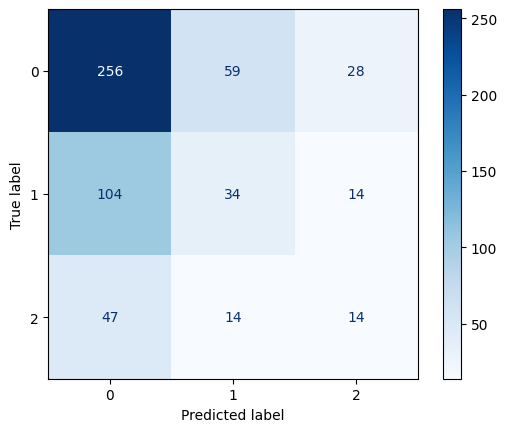

In [14]:

# Split the data into features (X) and target (y)
X = df_batter.drop(['PITCH_TYPE_enc', 'BATTER_ID'], axis=1)
y = df_batter['PITCH_TYPE_enc']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, y_train = X, y
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
#rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rf.fit(X_train, y_train)
print("training score: ", rf.score(X_train, y_train))
print("testing score: ", rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

# Evaluate the model's performance
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report for precision, recall, f1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix directly using scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

### Algorithm 2. Gradient Boosting

training score:  0.5989471631897056
testing score:  0.5964912280701754
Accuracy: 0.60

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.94      0.74       343
           1       0.45      0.10      0.16       152
           2       0.43      0.04      0.07        75

    accuracy                           0.60       570
   macro avg       0.50      0.36      0.32       570
weighted avg       0.54      0.60      0.50       570



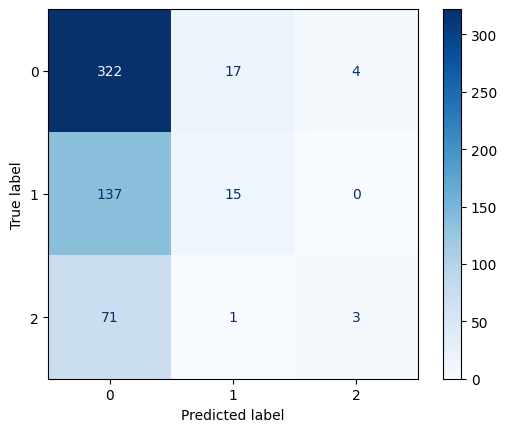

In [15]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=412)

# Fit the model on the training data
gb_clf.fit(X_train, y_train)

print("training score: ", gb_clf.score(X_train, y_train))
print("testing score: ", gb_clf.score(X_test, y_test))

# Step 5: Make predictions on the test data
y_pred = gb_clf.predict(X_test)

# Step 6: Evaluate the model's performance
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report for precision, recall, f1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))


from sklearn.metrics import ConfusionMatrixDisplay

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix directly using scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


### Algorithm 3. Logistic Regression

training score:  0.5599532072528758
testing score:  0.6017543859649123
Accuracy: 0.60

Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       343
           1       0.50      0.01      0.01       152
           2       0.00      0.00      0.00        75

    accuracy                           0.60       570
   macro avg       0.37      0.33      0.25       570
weighted avg       0.50      0.60      0.46       570



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metr

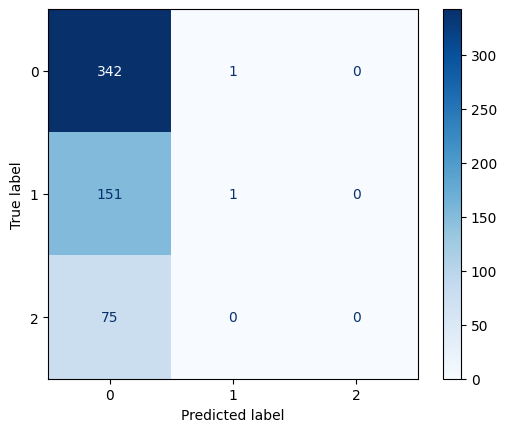

In [16]:
lr_clf = LogisticRegression()

# Fit the model on the training data
lr_clf.fit(X_train, y_train)

print("training score: ", lr_clf.score(X_train, y_train))
print("testing score: ", lr_clf.score(X_test, y_test))

# Step 5: Make predictions on the test data
y_pred = lr_clf.predict(X_test)

# Step 6: Evaluate the model's performance
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report for precision, recall, f1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred))


from sklearn.metrics import ConfusionMatrixDisplay

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix directly using scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


## Use the trained model to simulate all data to calculate Pitch type probability for each batter
## Change the input GAME_YEAR to 2024

In [17]:
df_all = df_fea.copy()

df_all['GAME_YEAR'] = 2024

In [18]:
X = df_all.drop(['PITCH_TYPE_enc', 'BATTER_ID'], axis=1)
y = df_all['PITCH_TYPE_enc']
print(X.shape)

(1285688, 10)


In [19]:
#Use trained model for this Batter to predict all the data
y_pred=rf.predict(X)

### count predicted PITCH type (0-FB, 1-BB, 2-OS) and normalize to the result

In [20]:
a1, a2=np.unique(y_pred, return_counts=True)
#print(a1)
print("FB, BB, OS count: ", a2)

# normalize the counts to be probability
count_prob = []
for a in a2:
    count_prob.append(round(a/a2.sum(), 3))

print("FB, BB, OS ratio: ", count_prob)

FB, BB, OS count:  [933565 257865  94258]
FB, BB, OS ratio:  [0.726, 0.201, 0.073]


## Apply the above flow to all batters & put the results into dataframe as submission form

In [ ]:
# iterate through all the batters 
df_all = df_fea.copy()
df_all['GAME_YEAR'] = 2024
X_all = df_all.drop(['PITCH_TYPE_enc', 'BATTER_ID'], axis=1)
y_all = df_all['PITCH_TYPE_enc']

BATTER_ID = []
PITCH_TYPE_FB=[]
PITCH_TYPE_BB=[]
PITCH_TYPE_OS=[]

for batter in batter_id_list[:5]:
    print("BATTER ID: ", batter)
    BATTER_ID.append(batter)
    df_bat = df_fea[df_fea['BATTER_ID']==batter]
    
    X = df_bat.drop(['PITCH_TYPE_enc', 'BATTER_ID'], axis=1)
    y = df_bat['PITCH_TYPE_enc']

    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X, y)

    y_all_pred=rf_clf.predict(X)
    savePlot(batter, rf_clf, X)
    
    
    a1, a2=np.unique(y_all_pred, return_counts=True)

    count_prob = []
    for a in a2:
        count_prob.append(round(a/a2.sum(), 3))

    print("FB, BB, OS ratio: ", count_prob)
    PITCH_TYPE_FB.append(count_prob[0])
    PITCH_TYPE_BB.append(count_prob[1])
    PITCH_TYPE_OS.append(count_prob[2])

submission_df = pd.DataFrame(columns=['BATTER_ID', 'GAME_YEAR', 'PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS'])
submission_df['BATTER_ID']=BATTER_ID
submission_df['GAME_YEAR']=2024
submission_df['PITCH_TYPE_FB']=PITCH_TYPE_FB
submission_df['PITCH_TYPE_BB']=PITCH_TYPE_BB
submission_df['PITCH_TYPE_OS']=PITCH_TYPE_OS
    
submission_df

BATTER ID:  605141


### Save results to final csv file

In [ ]:

#merge csv files
id_with_names = pd.read_csv('predictions.csv')
merged_data = pd.merge(submission_df, id_with_names[['BATTER_ID', 'PLAYER_NAME']], on="BATTER_ID", how="left")

cols = merged_data.columns.tolist()
cols.insert(1, cols.pop(cols.index('PLAYER_NAME')))
merged_data = merged_data[cols]
merged_data


In [ ]:
# save to submission csv
merged_data.to_csv('submission.csv', index=False)

### Use SHAP values to explain the output of the model. See how each feature affects each final prediction and the significance of each feature compared to others.

In [21]:
import os
import gc
def savePlot(idnum, rf, xall):
    d = "BatterID:" + str(idnum)
    os.mkdir(d)
    # Initialize SHAP explainer for tree-based models (RandomForestClassifier)
    explainer = shap.Explainer(rf)
    
    # Calculate SHAP values (this will return a list of SHAP values for each class)
    shap_values = explainer.shap_values(xall)
    
    # Expected values for each class (used in force plots)
    expected_values = explainer.expected_value
    
    # Extract SHAP values for class 0/fastball 
    shap_values_class_0 = shap_values[:, :, 0]  # SHAP values for class 0

    shap.summary_plot(shap_values_class_0, xall, feature_names=xall.columns.tolist(), show=False)
    fig_FB = plt.gcf()  # Get current figure and assign to variable
    fig_FB.savefig(d + '/' + str(idnum) + 'FBsummary.png', bbox_inches='tight')
    
    
    #depedence plot between fastball prediction and pitcher ID
    shap.dependence_plot("PITCHER_ID", shap_values[:,:,0], xall, interaction_index="PITCHER_ID", show=False)
    plt.savefig(d+ '/'+ str(idnum) + '_PITCHER.png')
    plt.clf()
    
    feature_index = xall.columns.get_loc("PITCHER_ID")
    # Extract the X-coordinates (feature values) for 'PITCH_NUMBER'
    x_values = xall["PITCHER_ID"].values
    
    # Extract the Y-coordinates (SHAP values for class 0/fastball)
    y_values = shap_values[:, feature_index, 0]  # SHAP values for class 0 and the selected feature
    
    # Combine X and Y values into a DataFrame for better visualization
    coordinates = pd.DataFrame({'Feature Value (X)': x_values, 'SHAP Value (Y)': y_values})
    coordinates = coordinates.reindex(coordinates['SHAP Value (Y)'].abs().nlargest(5).index)
    coordinates.to_csv(d + '/' + str(idnum) + 'top10PitchersFastball.csv', index=False)

    print(f"Saving force plots for batter {idnum}")
    # Force plot for the first observation and fastball
    force_plot = shap.force_plot(explainer.expected_value[0], shap_values[0, :, 0], xall.iloc[0, :], feature_names=xall.columns.tolist(), show=False)
    shap.save_html(d + '/' + str(idnum) + '_FBforceplot.html', force_plot)
    plt.clf()
    
    # Force plot for the first observation and breaking ball
    force_plot = shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], xall.iloc[0, :], feature_names=xall.columns.tolist(), show=False)
    shap.save_html(d + '/' + str(idnum) + '_BBforceplot.html', force_plot)
    plt.clf()
    
    # Force plot for the first observation and off speed pitch
    force_plot = shap.force_plot(explainer.expected_value[2], shap_values[0, :, 2], xall.iloc[0, :], feature_names=xall.columns.tolist(), show=False)
    shap.save_html(d + '/' + str(idnum) + '_OSforceplot.html', force_plot)
    plt.clf()

    gc.collect()

Saving force plots for batter 457759


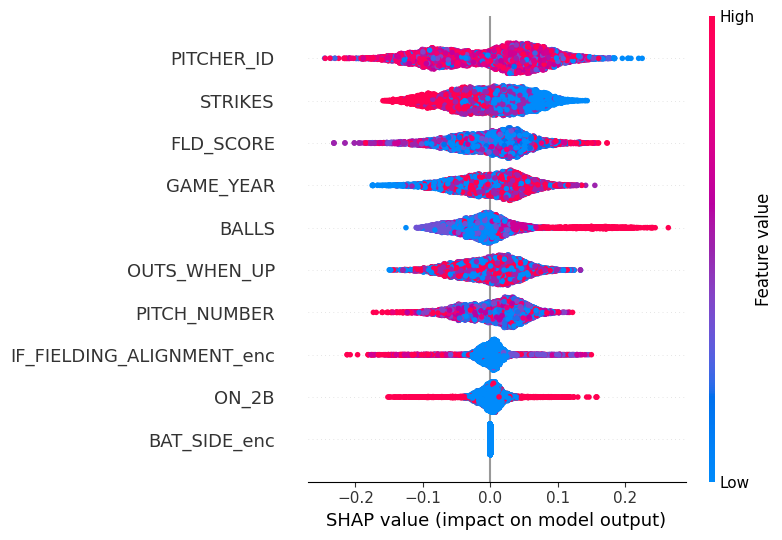

<Figure size 600x500 with 0 Axes>

In [25]:
df_bat = df_fea[df_fea['BATTER_ID']==457759]

X = df_bat.drop(['PITCH_TYPE_enc', 'BATTER_ID'], axis=1)
y = df_bat['PITCH_TYPE_enc']

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y)

y_all_pred=rf_clf.predict(X)
savePlot(457759, rf_clf, X)